# UAV Turbidity Retrieval Performance Evaluation

In paper, Section 3.2.3.3. 

# FILTERING THE ORG AND INPAINTED RGB

In [5]:
!pip install tabulate


In [2]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
org_data = pd.read_csv('refined_sampling/spectral_info_DSTT_ORG_line10.csv')
inpainted_data = pd.read_csv('refined_sampling/spectral_info_DSTT_INPAINTED_line10.csv')

# Define a function to check the difference between two values based on a threshold
def check_difference(value_org, value_inpainted, threshold):
    return abs((value_org - value_inpainted) / value_org) <= threshold

# Set thresholds for band differences
threshold_band_0 = 0.076  # 4%
threshold_band_1 = 0.076  # 3.4%
threshold_band_2 = 0.076 # 4.6%

# Create an empty DataFrame to store the filtered rows
filtered_data = pd.DataFrame(columns=org_data.columns)

# Iterate through each row in the ORG dataset and find similar rows in the INPAINTED dataset
for org_index, org_row in org_data.iterrows():
    org_band_0 = org_row['band_0']
    org_band_1 = org_row['band_1']
    org_band_2 = org_row['band_2']

    # Filter rows in INPAINTED dataset based on band differences
    filtered_rows = inpainted_data[
        check_difference(org_band_0, inpainted_data['band_0'], threshold_band_0) &
        check_difference(org_band_1, inpainted_data['band_1'], threshold_band_1) &
        check_difference(org_band_2, inpainted_data['band_2'], threshold_band_2)
    ]
   
   
    # If filtered rows are found, append them to the filtered_data DataFrame
    if not filtered_rows.empty:
        filtered_data = pd.concat([filtered_data, org_row.to_frame().transpose()])

# Save the filtered data to a new CSV file
filtered_data.to_csv('refined_sampling/DSTT_Line10_filtered_data.csv', index=False)

# Identify the observation numbers from org_data that were not extracted
not_extracted_observation_numbers = org_data[~org_data['observation_number'].isin(filtered_data['observation_number'])]['observation_number']

# Filter rows from inpainted_data based on observation numbers
filtered_inpainted_data = inpainted_data[inpainted_data['observation_number'].isin(not_extracted_observation_numbers)]

# Filter rows from org_data based on observation numbers
filtered_obstructed_data = org_data[org_data['observation_number'].isin(not_extracted_observation_numbers)]

# Save the filtered inpainted data to a new CSV file
filtered_inpainted_data.to_csv('refined_sampling/DSTT_Line10_filtered_inpainted_data.csv', index=False)

# Save the filtered obstructed data to a new CSV file
filtered_obstructed_data.to_csv('refined_sampling/DSTT_Line10_filtered_obstructed_data.csv', index=False)


# REGRESSION MODEL

In [3]:
#Multivariate models 
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from tabulate import tabulate

# Load the filtered data from CSV file
filtered_data = pd.read_csv('refined_sampling/DSTT_Line1&Line10_filtered_data.csv').dropna()
#filtered_data_l3 = pd.read_csv('refined_sampling/DSTT_Line3_filtered_data.csv').dropna()
#filtered_data = pd.concat([filtered_data_l1, filtered_data_l3])
filtered_data['R/G'] = filtered_data['band_0'] / filtered_data['band_1']
filtered_data['R/B'] = filtered_data['band_0'] / filtered_data['band_2']
filtered_data['G/B'] = filtered_data['band_1'] / filtered_data['band_2']

X = filtered_data.iloc[:,4:7].values
y = filtered_data.iloc[:,1].values

# creating a regression model 
model = LinearRegression()

# fitting the model 
model.fit(X,y)

# Calculate R2 and RMSECV
multivariate_rmsecv_band = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean())
# Compute R2
r2_multivariate_band = r2_score(y, model.predict(X))

results = []
# Store the results for individual bands
results.append({
    'Linear-Log RMSECV': multivariate_rmsecv_band,
    'Linear-Log R2': r2_multivariate_band,
    'Adjusted R2': round((1-(1-r2_multivariate_band)*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)),4)
})


print(np.min(y), np.max(y))
results


1.79 5.01


[{'Linear-Log RMSECV': 0.701400876494845,
  'Linear-Log R2': 0.469866554426805,
  'Adjusted R2': 0.4602}]

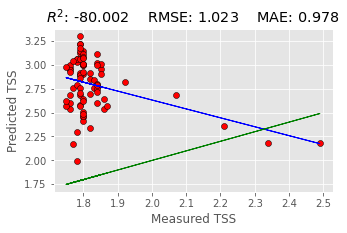

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
#Apply multivariate model to inpainted data
# Load the inpainted data from CSV file
inpainted_data = pd.read_csv('refined_sampling/DSTT_Line1_filtered_inpainted_data.csv').dropna()
#inpainted_data_l3 = pd.read_csv('refined_sampling/DIP_Line3_filtered_inpainted_data.csv').dropna()
#inpainted_data = pd.concat([inpainted_data_l1, inpainted_data_l3])
inpainted_data['R/G'] = inpainted_data['band_0'] / inpainted_data['band_1']
inpainted_data['R/B'] = inpainted_data['band_0'] / inpainted_data['band_2']
inpainted_data['G/B'] = inpainted_data['band_1'] / inpainted_data['band_2']

X_inp= inpainted_data.iloc[:,4:7].values

y_obs = inpainted_data['turbidity'].values
y_pred = model.predict(X_inp)

r2_multivariate_band_inpainted = r2_score(y_obs, y_pred)

#Plot R2 graph
z = np.polyfit(y_obs.astype('float'), y_pred,1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(y_obs, y_pred, c='red', edgecolor='k')
    ax.plot(y_obs, z[1] + z[0] * y_obs, c='blue', linewidth=1)
    ax.plot(y_obs, y_obs, color='green', linewidth=1)
    plt.title('$R^{2}$: ' + str(round(r2_score(y_obs, y_pred),3))
               + '    RMSE: ' + str(round(np.sqrt(mean_squared_error(y_obs, y_pred)), 3))
               + '    MAE: ' + str(round(mean_absolute_error(y_obs, y_pred),3)))
    plt.xlabel('Measured TSS')
    plt.ylabel('Predicted TSS')
plt.show()
#print(r2_multivariate_band_inpainted)
#print(y_obs, y_pred)
